In [ ]:
!pip install mtcnn 
!pip install imutils 
!pip install face_detection

#!tar -xf /kaggle/input/lfwpeople/lfw-funneled.tgz

In [1]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from tensorflow import keras 
import tensorflow as tf 
import os, tqdm
import numpy as np 
from imutils import paths 
import shutil
import random
import cv2 
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Lambda, \
                                    ReLU, ELU, AveragePooling2D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications import resnet

In [ ]:
dirs = os.listdir("lfw_funneled")
np.random.seed(42)
random_dirs = np.random.choice(dirs, 2500, replace=False)

In [ ]:
import shutil 

def create_siamese_directory(dirs): 
    """
        this function will create a new directory named siamese data, which will have a random directories from the 
        lfw dataset.
        Params:
            dirs(type: List): directories, needed to be copied to siamese data.
        Return(type: None
        try: )
    """
    if not os.path.exists("siamese_data"): 
        os.mkdir("siamese_data")

    for folder in dirs:
        src = "lfw_funneled/" + folder
        dst = f"/kaggle/working/siamese_data/{folder}"

        shutil.copytree(src, dst)

In [ ]:
# creating siamese data directory from lfw_dataset.
create_siamese_directory(random_dirs)

In [ ]:
def detect_face(mtcnn_detector, filename, shape):
    """
        this function, uses the mtcnn detector to detect the face from the siamese dataset.
        Params:
            mtcnn_detector(type: tf.keras.Model): mtcnn model, used to detect face.
            filename(type: str): filename or filepath of the image.
            shape(type: tuple): image shape, that the detected face, needed to be reshaped.
        Return(type: np.NdArray)
            it returns the image, that is detected face.
    """
    img = Image.open(filename)
    img = img.convert('RGB')
    pixels = np.asarray(img)
    results = mtcnn_detector.detect_faces(pixels)
    
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    face = pixels[y1:y2, x1:x2]

    image = Image.fromarray(face)
    image = image.resize(shape)
    face_array = asarray(image)
    
    return face_array

def generate_face_detected_data(detector, directory_path): 
    """
        this function, will does a face detection with the siamese_data directory and will override the files, that 
        have successfully detected the face. If not the file will be deleted.
        Params:
            detector(type: tf.keras.Model): mtcnn model, used to detect face.
            directory_path(type: str): directory path of the siamese data.
    """
    for directory in tqdm.tqdm(os.listdir(directory_path)): 
        for file in os.listdir(directory_path + directory): 

            try: 
                src_filename = directory_path + directory + "/" + file
                img = detect_face(detector, src_filename, (180, 180))
                
                if not np.all(img): 
                    raise ValueError("did'nt find a face")
                
            except Exception as error:
                os.remove(src_filename)
                continue
            
            else: 
                cv2.imwrite(src_filename, img)
                

In [ ]:
# creating a face detected images by overriding the existing files in siamese_data.
mtcnn_detector = MTCNN()
generate_face_detected_data(mtcnn_detector, "siamese_data/")

# checks the directory for emp
for folder in os.listdir("siamese_data"): 
    try:
        files = "siamese_data/" + folder
        if len(os.listdir(files)) <= 0:
            os.rmdir(files)
    
    except Exception as err:
        return err

# removing the directoies, that contains only one file,
for dir_name in os.listdir("siamese_data/"): 
    try:
        dir_path = os.path.join("siamese_data", f"{dir_name}")

        if len(os.listdir(dir_path)) <= 1:
            shutil.rmtree(dir_path)
    
    except Exception as err:
        return err

In [ ]:
from imutils import paths 

img_files_path = (list(paths.list_files('siamese_data')))

## **Offline Triplet Mining**

In [2]:
def get_triplet_data(dir_path, dirs_list, img_shape): 
    """
        this function will generate a triplet data from the siamese dataset.
        Params:
            dir_path(type: str): directory path for the source data(siamese data).
            dirs_list(type: List): List of sub-directories in the siamese data directory, 
                                    that has a more than 1 image.
        Return(type: np.narray, np.narray, np.narray)
            returns the positives, negatives, anchors.
    """
    positives = []
    anchors = []
    negatives = []
        
    for pos_dir_name in tqdm.tqdm(dirs_list): 
        try: 
            positive_dir_path = os.path.join(dir_path, pos_dir_name)

            files = os.listdir(positive_dir_path)

            if len(files) <= 0:
                raise FileNotFoundError(f"No files are in the directory, {random_dir_pos}")

            for positive_file in files: 
                try: 
                    files_copy = files.copy()
                    dirs_list_copy = dirs_list.copy()
                    files_copy.remove(positive_file)
                    random_anchor_file = random.choice(files_copy)

                    dirs_list_copy.remove(pos_dir_name)

                    random_dir_neg = random.choice(dirs_list_copy)
                    random_neg_dir_path = os.path.join(dir_path, random_dir_neg)
                    
                    
                    neg_dir_path = os.path.join(dir_path, random_dir_neg)
                    random_files_neg = os.listdir(neg_dir_path)
                    random_negative_file = random.choice(random_files_neg)

                    positive_img_path = os.path.join(positive_dir_path, positive_file) 
                    anchor_img_path = os.path.join(positive_dir_path, random_anchor_file)
                    negative_img_path = os.path.join(random_neg_dir_path, random_negative_file)

                    positive_img = cv2.imread(positive_img_path)
                    negative_img = cv2.imread(negative_img_path)
                    anchor_img = cv2.imread(anchor_img_path)
                    
                  #  plt.imshow(positive_img)
                    
                    positive_img = cv2.resize(positive_img, (180, 180))
                    negative_img = cv2.resize(negative_img, (180, 180))
                    anchor_img = cv2.resize(anchor_img, (180, 180))
                    
                    if not np.all(positive_img) or not np.all(negative_img) or not np.all(anchor_img):                    
                        raise ValueError("No image is read from the file.")

                except Exception as error:
                    #print(error)
                    continue
                
                else:
                    positives.append(positive_img)
                    anchors.append(anchor_img)
                    negatives.append(negative_img)

        except Exception as err:
            raise err
            
    return np.array(positives), np.array(negatives), np.array(anchors)
        

In [3]:
def plot_triplets(n_sample, anchor_data, pos_data, neg_data, rows, columns):
    """
        this function, will plot the triplet image with the help of the matplotlib.
        Params:
            n_sample(type: Int): Number of sample, needed to be plotted.
            pos_data(type: np.array): positive samples.
            neg_data(type: np.array): negative samples.
            anchor_data(type: np.array): anchor samples.
            rows(type: Int): number of rows in the subplot(matplotlib subplot) 
            columns(type: Int): number of columns in the subplot(matplotlib subplot) 
            
        Return(type: None)
    """
    
    assert len(pos_data) == len(neg_data), "Dimension for positives, negatives and anchors does'nt match"
    assert len(pos_data) == len(anchor_data), "Dimension for positives, negatives and anchors does'nt match"
    assert n_sample * 3 == rows*columns, "Number of rows and cols in subplot, dos'nt match the number of input data"
    assert pos_data.shape[0] == n_sample, "Number of sample, does'nt match the input data shape"
    
    def show(ax, image, type_img):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(type_img)

    fig = plt.figure(figsize=(8, 8))

    axs = fig.subplots(rows, columns)
    for i in range(n_sample):
        show(axs[i, 0], anchor_data[i], "Anchor")
        show(axs[i, 1], pos_data[i], "Positive")
        show(axs[i, 2], neg_data[i], "Negative")

In [4]:
positives, negatives, anchors = get_triplet_data("siamese_data/", os.listdir("siamese_data"), (180, 180, 3))

100%|██████████| 189/189 [00:01<00:00, 112.99it/s]


In [5]:
negatives.shape

(468, 180, 180, 3)

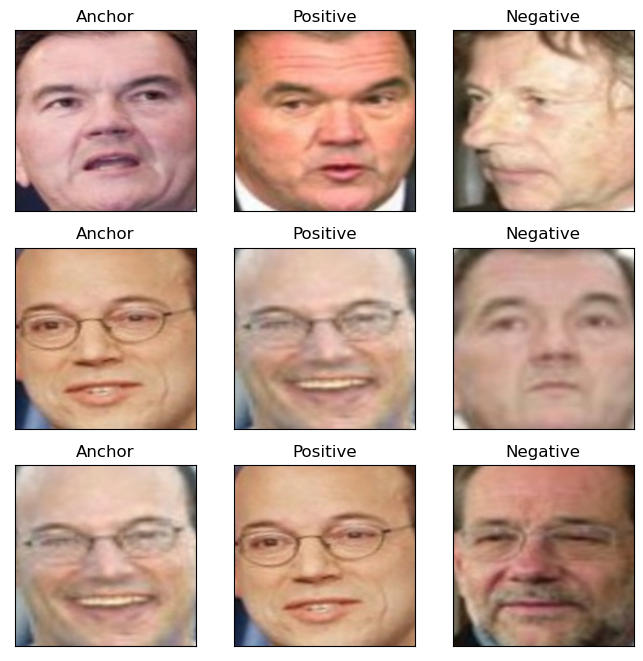

In [6]:
plot_triplets(3, anchors[128: 131], positives[128: 131], negatives[128: 131], 3, 3)

In [7]:
def parse_images(img_path): 
    """
        this function, will do a preprocessing for using tf.image module.
        Params:
            img_path(type: str): path of the image, needed to be read.
        Return(type: tf.Tensor)
            function, will return the image tensor
    """
    image_string = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image


def create_tf_dataset(data, batch_size, buffer_size): 
    """
        this function, will create a tensor.data.Dataset object, which is nothing a tensorflow tensor object.
        Params:
            data(type: np.ndarray): array of data, that needed to be converted into tensor.
            batch_size(type: Int): Number of Batches, needed to be created.
            buffer_size(type: Int): Buffer Size in the shuffle
    """
    tensorflow_dataset = (tf.data.Dataset.from_tensor_slices(data)
                                          .shuffle(buffer_size=buffer_size)
                                          .batch(batch_size, drop_remainder=True)
                                          .prefetch(tf.data.experimental.AUTOTUNE))
    
    return tensorflow_dataset

In [8]:
#positive_ds = create_tf_dataset(positives, 32, 1024)
#negative_ds = create_tf_dataset(negatives, 32, 1024)
#anchor_ds = create_tf_dataset(anchors, 32, 1024)

negatives= negatives.reshape(negatives.shape[0], 1, 180, 180, 3)
positives= positives.reshape(negatives.shape[0], 1, 180, 180, 3)
anchors= anchors.reshape(negatives.shape[0], 1, 180, 180, 3)

triplet_df = np.concatenate([anchors, positives, negatives], axis=1)

#triplet_df = zip(anchors, positives, negatives)

triplet_ds = create_tf_dataset(triplet_df, 32, 1024)

#triplet_ds = tf.data.Dataset.zip((anchor_ds, positive_ds , negative_ds)).shuffle(buffer_size=1024)

In [41]:
class SiameseEncoder(keras.Model):
    def __init__(self, input_dims, out_dims, pretrained_model_type, base_encoder_trainable=False): 
        super(SiameseEncoder, self).__init__()
        self.input_dims = input_dims 
        self.out_dims = out_dims 
        
        self.base_encoder = resnet.ResNet50(
                                input_shape=self.input_dims,
                                weights="imagenet",
                                include_top=False
                            )
        if base_encoder_trainable:
        
            for layer in self.base_encoder.layers:
                if layer.name in ["conv5_block1_out", "conv5_block2_out", "conv5_block3_out",
                                                  "conv4_block1_out", "conv4_block2_out", "conv4_block3_out"]:
                    trainable = True
                trainable = False
        
        self.flatten = Flatten()
        self.dense1 =  Dense(1024, activation="relu")
        self.dense2 =  Dense(256, activation="relu")
        self.dropout = Dropout(0.2)
        self.bn = BatchNormalization()
        self.dense3  = Dense(self.out_dims, activation="relu")
        self.emb = keras.layers.Embedding(256, 256)
        
    def call(self, tensor): 
        x = self.base_encoder(tensor)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.bn(x)
        
      #  x = self.dense1(x)
       # x = self.dropout(x)
      #  x = self.bn(x)
        
        x = self.dense3(x)
       # x = self.bn(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x 

In [36]:
class DistanceLayer(keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        anchor, positive, negative = inputs
      #  ap_distance = tf.math.sqrt(tf.reduce_sum(tf.square(anchor - positive), -1))
       # an_distance =  tf.math.sqrt(tf.reduce_sum(tf.square(anchor - negative), -1))
        
        anchor = anchor/tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(anchor),axis=1,keepdims=True),1e-10))
        positive = positive/tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(positive),axis=1,keepdims=True),1e-10))
        negative = negative/tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(negative),axis=1,keepdims=True),1e-10))

        ap_distance = tf.sqrt(tf.reduce_sum(tf.square(anchor-positive), axis=1))
        an_distance = tf.sqrt(tf.reduce_sum(tf.square(anchor-negative), axis=1))
        
        return (ap_distance, an_distance)
    
class SiameseNetwork(keras.Model): 
    def __init__(self, siamese_encoder): 
        super(SiameseNetwork, self).__init__()
        self.siamese_encoder = siamese_encoder 
        
    def call(self, inputs): 
        anchors = inputs[0]
        positives = inputs[1]
        negatives = inputs[2]                
        
        pos_embeddings = self.siamese_encoder(resnet.preprocess_input(positives))
        neg_embeddings = self.siamese_encoder(resnet.preprocess_input(negatives))
        anchor_embeddings = self.siamese_encoder(resnet.preprocess_input(anchors))
        
        return anchor_embeddings, pos_embeddings, neg_embeddings
       # anchor_positive_dis, anchor_neg_dis = self.out_layer([anchor_embeddings, pos_embeddings, neg_embeddings])
                
        #return anchor_pos_dis, anchor_neg_dis

In [37]:
class SiameseModel(keras.Model): 
    def __init__(self, siamese_network, margin, distance_layer):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.distance_layer = distance_layer
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
    def call(self, inputs):
        return self.siamese_network(inputs) 
    
    def train_step(self, inputs, optimizer=None, loss_tracker=None):
        
        with tf.GradientTape() as tape: 
            anchor_embeddings, pos_embeddings, neg_embeddings = siamese_network(inputs)  
            loss_val = self.compute_triplet_loss([anchor_embeddings, pos_embeddings, neg_embeddings])
        
        params = self.siamese_network.trainable_weights
        grads = tape.gradient(loss_val, params)
        self.optimizer.apply_gradients(zip(grads, params))
        
        self.loss_tracker.update_state(loss_val)
        return {"loss": self.loss_tracker.result()}
    
    def val_step(self, inputs, loss_func, metric_func):
        pass 
    
    def compute_triplet_loss(self, embeddings): 
        ap_distance, an_distance = self.distance_layer(embeddings)
        
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    

In [38]:
from collections import defaultdict 

def train_model(model, training_data, validation_data, epochs):

    for epoch in range(epochs): 
        epoch_loss = None
        for batch_indx, (training_batch) in \
                        tqdm.tqdm(enumerate(training_data), total=len(training_data)): 
            
            training_batch = tf.experimental.numpy.moveaxis(training_batch, 1, 0)

            loss = model.train_step(training_batch, opt, loss_func)
            epoch_loss = loss.get("loss")

        print(f"Epoch {epoch} loss: {epoch_loss}")
       # print(f"Epoch {epoch} loss: {epoch_train_loss} val_loss: {epoch_val_loss} accuracy: {epoch_train_acc} val_accuracy: {epoch_val_acc}")
        
    return model

In [42]:
opt = keras.optimizers.Adam()
loss_func = keras.metrics.Mean(name="loss")

encoder = SiameseEncoder((180, 180, 3), 256, "resnet", base_encoder_trainable=True)
distance_layer = DistanceLayer()
siamese_network = SiameseNetwork(encoder)
siamese_model = SiameseModel(siamese_network, 0.5, distance_layer)
siamese_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

In [43]:
trained_model = train_model(siamese_model, triplet_ds, None, 50)

100%|██████████| 14/14 [00:35<00:00,  2.53s/it]


Epoch 0 loss: 0.40682312846183777


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 1 loss: 0.3344457149505615


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Epoch 2 loss: 0.2759053707122803


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch 3 loss: 0.23105278611183167


100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


Epoch 4 loss: 0.19648820161819458


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Epoch 5 loss: 0.1686098873615265


100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


Epoch 6 loss: 0.14674176275730133


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 7 loss: 0.1304602473974228


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 8 loss: 0.11709709465503693


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Epoch 9 loss: 0.10593044012784958


100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


Epoch 10 loss: 0.09699073433876038


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch 11 loss: 0.08942557126283646


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Epoch 12 loss: 0.08288555592298508


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 13 loss: 0.07726791501045227


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 14 loss: 0.0722246989607811


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Epoch 15 loss: 0.06786798685789108


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Epoch 16 loss: 0.06397601962089539


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 17 loss: 0.060426000505685806


100%|██████████| 14/14 [00:09<00:00,  1.47it/s]


Epoch 18 loss: 0.05727719888091087


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Epoch 19 loss: 0.05442557856440544


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch 20 loss: 0.0518953911960125


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch 21 loss: 0.04955677315592766


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Epoch 22 loss: 0.047442950308322906


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 23 loss: 0.04547760263085365


100%|██████████| 14/14 [00:08<00:00,  1.58it/s]


Epoch 24 loss: 0.04370637983083725


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Epoch 25 loss: 0.042037226259708405


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Epoch 26 loss: 0.04050634428858757


100%|██████████| 14/14 [00:09<00:00,  1.53it/s]


Epoch 27 loss: 0.03909223526716232


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Epoch 28 loss: 0.03783821314573288


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 29 loss: 0.03669380769133568


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch 30 loss: 0.03558892756700516


100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


Epoch 31 loss: 0.034533556550741196


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 32 loss: 0.03356887772679329


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch 33 loss: 0.03263675421476364


100%|██████████| 14/14 [00:09<00:00,  1.49it/s]


Epoch 34 loss: 0.031724195927381516


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 35 loss: 0.030919421464204788


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 36 loss: 0.03014799766242504


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Epoch 37 loss: 0.029406031593680382


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


Epoch 38 loss: 0.02869105152785778


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 39 loss: 0.02802218124270439


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch 40 loss: 0.027379747480154037


100%|██████████| 14/14 [00:09<00:00,  1.51it/s]


Epoch 41 loss: 0.02674037590622902


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 42 loss: 0.02614428475499153


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 43 loss: 0.02560894563794136


100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


Epoch 44 loss: 0.025073643773794174


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]


Epoch 45 loss: 0.024624411016702652


100%|██████████| 14/14 [00:09<00:00,  1.55it/s]


Epoch 46 loss: 0.024161772802472115


100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


Epoch 47 loss: 0.023706423118710518


100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


Epoch 48 loss: 0.02324405498802662


100%|██████████| 14/14 [00:08<00:00,  1.57it/s]

Epoch 49 loss: 0.02280089445412159


In [ ]:
#siamese_model.fit(triplet_ds, epochs=100)

In [ ]:
encoder.save("siamese_encoder_offline_triplet")
trained_encoder = keras.models.load_model("siamese_encoder_offline_triplet")

Text(0.5, 1.0, 'NEGATIVE')

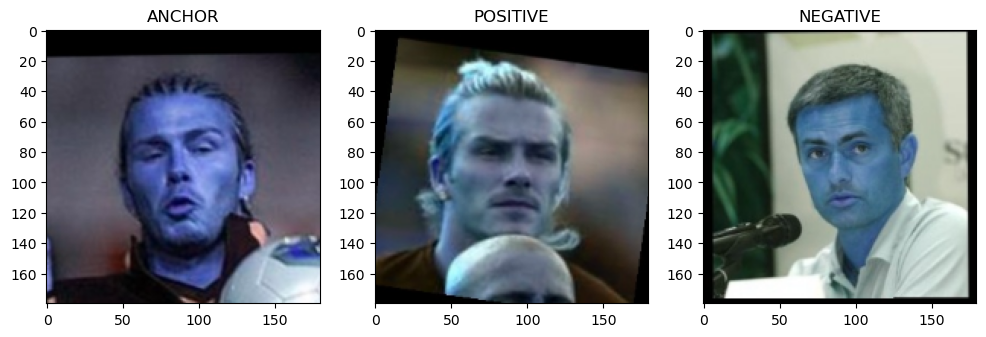

In [57]:
anchor = cv2.imread("lfw_funneled/David_Beckham/David_Beckham_0031.jpg")
anchor = cv2.resize(anchor, (180, 180))
pos = cv2.imread('lfw_funneled/David_Beckham/David_Beckham_0020.jpg')
pos = cv2.resize(pos, (180, 180))
neg = cv2.imread('/kaggle/working/lfw_funneled/Jose_Mourinho/Jose_Mourinho_0001.jpg')
neg = cv2.resize(neg, (180, 180))

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(anchor)
plt.title('ANCHOR')
plt.subplot(1,3,2)
plt.imshow(pos)
plt.title('POSITIVE')
plt.subplot(1,3,3)
plt.imshow(neg)
plt.title('NEGATIVE')

In [67]:
anc_emb = trained_encoder(np.expand_dims(anchor, 0))
pos_emb = trained_encoder(np.expand_dims(pos, 0))
neg_emb = trained_encoder(np.expand_dims(neg, 0))

In [55]:
def distance(a,b):
    a/= np.sqrt(np.maximum(np.sum(np.square(a)),1e-10))
    b/= np.sqrt(np.maximum(np.sum(np.square(b)),1e-10))

    dist = np.sqrt(np.sum(np.square(a-b)))

    return dist

In [68]:
distance(anc_emb, pos_emb)

0.26954556

In [70]:
distance(anc_emb, neg_emb)

0.3263228